# Irony Simulations
## Imports

In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from typing import Tuple, Optional

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from util import inference_util

import util.RAVDESS_dataset_util as Rd
from util.preprocess_util import *

from mvae_torch.config_args import ConfigModelArgs, ConfigTrainArgs
from mvae_torch.torch_mvae_util import Expert
from mvae_torch.train_mvae import *
import mvae_torch.multimodal_vae

# Double precision for numerical stability
torch.set_default_dtype(torch.float64)

## Generate Face Expression

In [3]:
Rd.emocat.values()

dict_values(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])

In [4]:
loaded_data = torch.load('../trained_models/ravdess_mvae_8k_NS_AN_01.save')

happy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


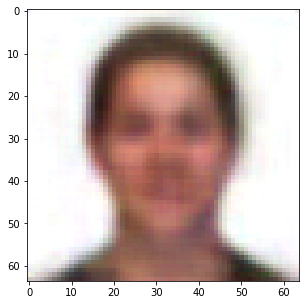

In [5]:
model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
model.load_state_dict(loaded_data['model_params'])
model.eval()

# Select an emotion category
emotion = 2
print(Rd.emocat[emotion])
emotion = torch.tensor([emotion]).to('cuda')

# Generate a face expression
r_image, _, _, _ = model(faces=None, emotions=emotion)
d_image = r_image
d_image = np.array(r_image.cpu().detach().numpy()[0]).transpose((1, 2, 0))
plt.figure(figsize = (5,5))
plt.imshow(d_image)

## Associate VA from image

In [6]:
# Predict the emotion category associated with the generated face expression
_, r_emotion, _, _ = model(faces=r_image, emotions=None)
pred = torch.argmax(r_emotion.cpu()).item()
print('Prediction: ', Rd.emocat[pred])

ca_loc = torch.tensor(EMOTION_CORE_AFFECT_MAP_LOC[Rd.emocat[pred]])
ca_dev = torch.tensor(EMOTION_CORE_AFFECT_MAP_STD_DEV[Rd.emocat[pred]])

facevalence_loc_dev = (ca_loc[0], ca_dev[0])
facearousal_loc_dev = (ca_loc[1], ca_dev[1])

valence_dist = dist.Normal(ca_loc[0], ca_dev[0])
arousal_dist = dist.Normal(ca_loc[1], ca_dev[1])

def norm_va(va):
    va = (va - (-1)) / (1 - (-1))
    if va >= 0.99: va = torch.tensor(0.99)
    if va <= 0: va = torch.tensor(0.01)
    return va

face_valence = norm_va(valence_dist.sample())
face_arousal = norm_va(arousal_dist.sample())

print('valence', face_valence, ' arousal', face_arousal)

Prediction:  happy
valence tensor(0.8893)  arousal tensor(0.8510)


In [7]:
STATES: Tuple[str, ...] = ("terrible", "ok", "amazing")
GOALS: Tuple[str, ...] = ("goal_state", "goal_valence", "goal_arousal")
AROUSAL_VALUES: Tuple[str, str] = ("low", "hi")

## Helper functions

## RSA model priors

In [8]:
STATE_PRIOR = [1, 50, 50]
# Here we introduce the RSA functions - we start with priors
def state_prior() -> str:
    probs: torch.Tensor = torch.FloatTensor(STATE_PRIOR)
    ix: torch.Tensor = pyro.sample("state", dist.Categorical(probs=probs))

    return STATES[ix.item()]

In [9]:
def valence_prior(state: str) -> float:
    # Prior probability of having LOW valence given a particular state
    ps = {"terrible": 0.99, "ok": 0.5, "amazing": 0.01}

    return ps[state]

In [10]:
def arousal_prior(state: str) -> float:
    # Prior probability of having HIGH arousal given a particular state
    ps = {"terrible": 0.9, "ok": 0.1, "amazing": 0.9}

    return ps[state]

In [11]:
def goal_state(goal: str, state, valence, arousal):
    if goal == "goal_state":
        return state
    elif goal == "goal_valence":
        return valence
    elif goal == "goal_arousal":
        return arousal

In [12]:
def goal_prior() -> str:
    # Uniform prior on the goals
    probs: torch.Tensor = torch.ones(len(GOALS)) / len(GOALS)
    goal_index: int = pyro.sample("goal", dist.Categorical(probs=probs)).item()

    return GOALS[goal_index]

In [13]:
def utterance_prior():
    # Utterances and states are equivalent in our case
    utterances = STATES

    # Uniform prior on the goals
    probs: torch.Tensor = torch.ones(len(utterances)) / len(utterances)
    utterance_index: int = pyro.sample("utterance", dist.Categorical(probs=probs)).item()

    return utterances[utterance_index]

## RSA model core functions

In [14]:
# Sampling valence given state and any other sources of valence
def sample_valence(state, high_valence_prob: Optional[float] = None) -> int:
    sampled_valence_prior = valence_prior(state)

    if high_valence_prob is None:
        sample = pyro.sample(
            "valence_prior",
            dist.Bernoulli(probs=sampled_valence_prior)
        ).item()

        # Recall that the probabilities are inverted for valence in the prior
        return -1 if sample == 1 else 1
    else:
        valence_prob_prior = torch.FloatTensor([sampled_valence_prior, 1 - sampled_valence_prior])
        # Invert, again, to get the probability of low valence
        valence_prob_other = 1 - torch.FloatTensor([high_valence_prob, 1 - high_valence_prob])

        # Cue integration between the prior and the rest
        composite_valence_prob = valence_prob_prior * valence_prob_other
        # Normalize
        composite_valence_prob = composite_valence_prob / torch.sum(composite_valence_prob)
        # Select probability of low valence
        valence_prob = composite_valence_prob[0]

        # Sample
        sample = pyro.sample(
            "valence",
            dist.Bernoulli(probs=valence_prob)
        ).item()

        # Recall that the probabilities are inverted for valence in the prior
        return -1 if sample == 1 else 1

In [15]:
# Sampling arousal given state and any other sources of arousal
def sample_arousal(state, high_arousal_prob: Optional[float] = None):
    sampled_arousal_prior = arousal_prior(state)

    if high_arousal_prob is None:
        sample = pyro.sample(
            "arousal_prior",
            dist.Bernoulli(probs=sampled_arousal_prior)
        ).item()

        # Here the probabilities are not inverted
        return AROUSAL_VALUES[int(sample)]
    else:
        arousal_prob_prior = torch.FloatTensor([sampled_arousal_prior, 1 - sampled_arousal_prior])

        # Cue integration between prior and other sources of arousal
        composite_arousal_prob = arousal_prob_prior * high_arousal_prob
        # Normalize
        composite_arousal_prob = composite_arousal_prob / torch.sum(composite_arousal_prob)
        # Choose the probability of HIGH valence
        arousal_prob = composite_arousal_prob[0]

        # Sample
        sample = pyro.sample(
            "arousal",
            dist.Bernoulli(probs=arousal_prob)
        ).item()

        # Here the probabilities are not inverted
        return AROUSAL_VALUES[int(sample)]

In [16]:
# Define RSA meaning function
def literal_interpretation(utterance: str, state: str) -> bool:
    # This is our meaning function
    return utterance == state

In [17]:
# Literal listener
@inference_util.marginal
def literal_listener(utterance, goal):
    sampled_state = state_prior()

    sampled_valence = sample_valence(sampled_state)
    sampled_arousal = sample_arousal(sampled_state)

    sampled_goal = goal_state(goal, sampled_state, sampled_valence, sampled_arousal)

    log_factor: torch.Tensor = torch.tensor(0.0) if literal_interpretation(utterance, sampled_state) \
        else torch.tensor(-999999.0)
    pyro.factor("literal_meaning", log_factor=log_factor)

    return sampled_goal

In [18]:
# Pragmatic speaker
@inference_util.marginal
def pragmatic_speaker(state: str, valence: float, arousal: float, goal: str) -> str:
    alpha_scaling_factor: float = 1.0

    sampled_goal: str = goal_state(goal, state, valence, arousal)

    with poutine.scale(scale=torch.tensor(alpha_scaling_factor)):
        sampled_utterance = utterance_prior()
        literal_listener_goal = literal_listener(sampled_utterance, goal)
        pyro.sample("listener", literal_listener_goal, obs=sampled_goal)

    return sampled_utterance

In [19]:
# Pragmatic listener
@inference_util.marginal
def pragmatic_listener(utterance: str):
    sampled_state = state_prior()
    sampled_valence = sample_valence(
        sampled_state,
        face_valence
    )
    sampled_arousal = sample_arousal(
        sampled_state,
        face_arousal
    )
    sampled_goal = goal_prior()

    speaker_marginal = pragmatic_speaker(sampled_state, sampled_valence, sampled_arousal, sampled_goal)
    pyro.sample("speaker", speaker_marginal, obs=utterance)

    return sampled_state, sampled_valence, sampled_arousal, sampled_goal

## Experiments

In [20]:
PLOT_WIDTH = 15
PLOT_HEIGHT = 8
matplotlib.rcParams['figure.figsize'] = [PLOT_WIDTH, PLOT_HEIGHT]

In [21]:
emotion.item()

2

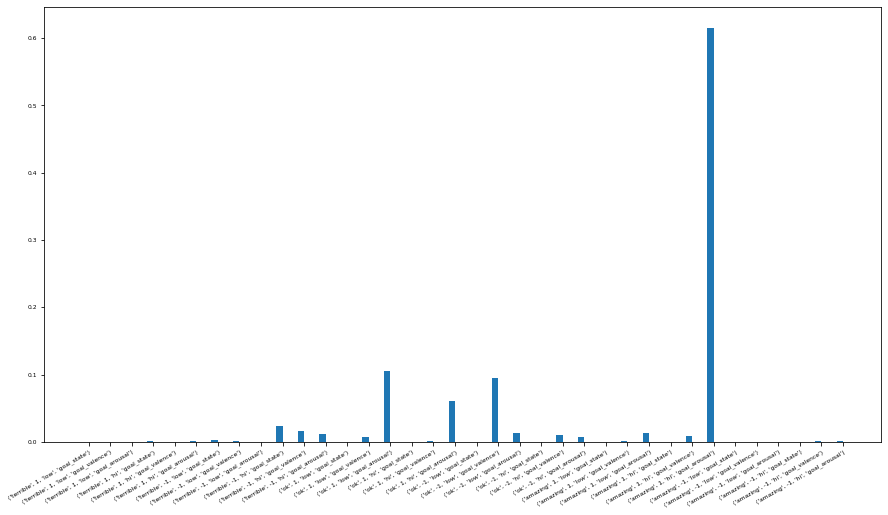

In [23]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("terrible")
fig = plt.figure()
inference_util.plot_dist(rsa_posterior)
#fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_terrible-"+emotion+".pdf")

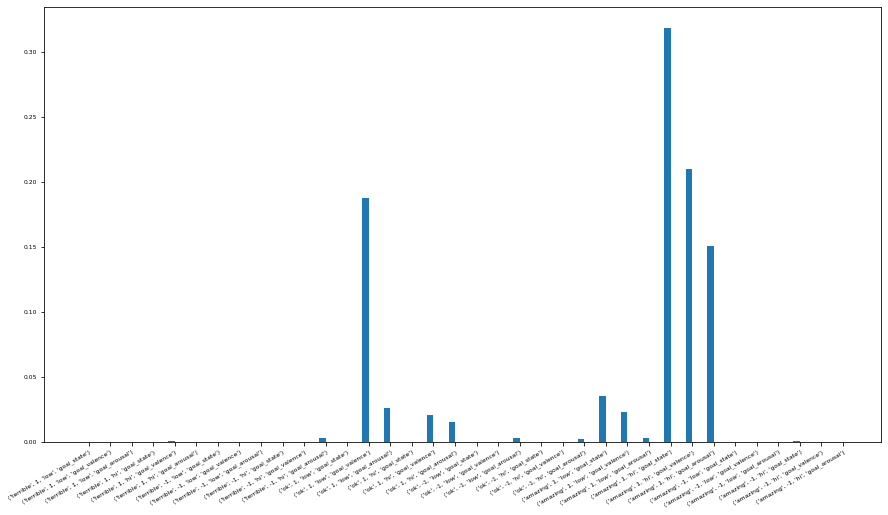

In [24]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("amazing")
fig = plt.figure()
inference_util.plot_dist(rsa_posterior)
#fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_amazing-"+emotion+".pdf")

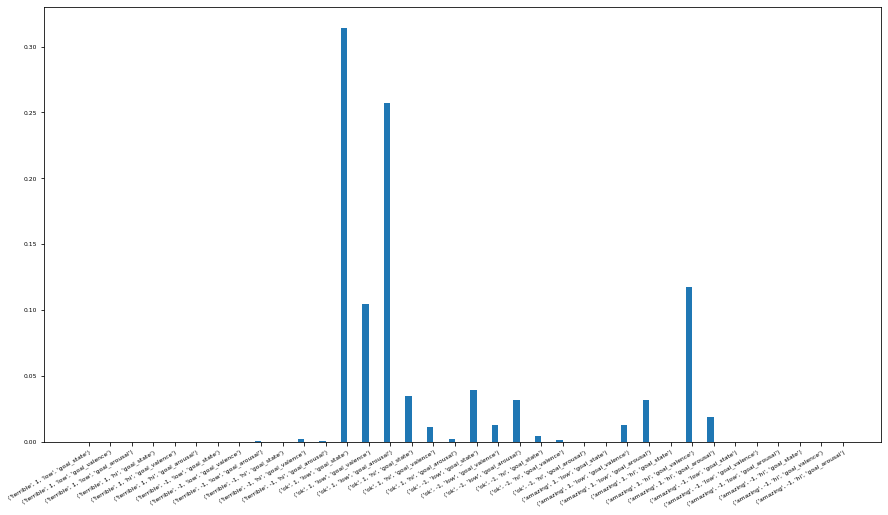

In [25]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("ok")
fig = plt.figure()
inference_util.plot_dist(rsa_posterior)
#fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_ok-"+emotion+".pdf")

### Altering the state prior

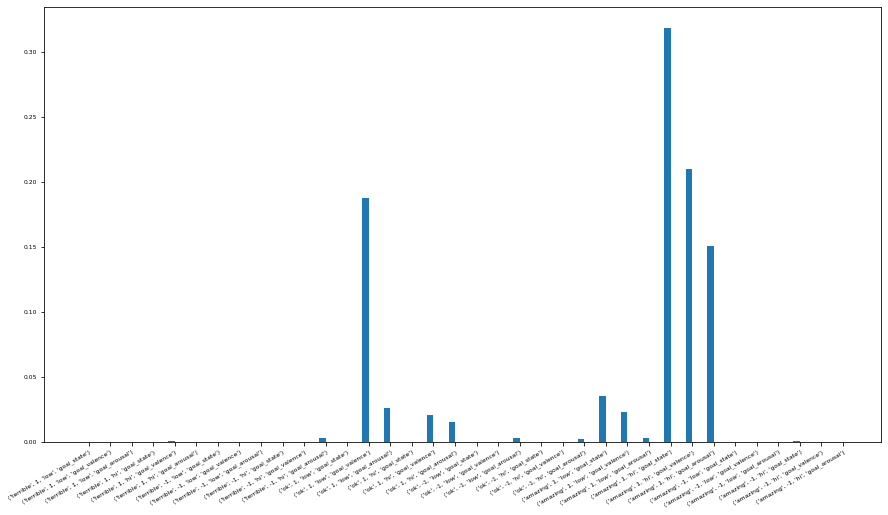

In [26]:
STATE_PRIOR = [1, 50, 1]
rsa_posterior = pragmatic_listener("amazing")
fig = plt.figure()
inference_util.plot_dist(rsa_posterior)
#fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_amazing_alt.pdf")

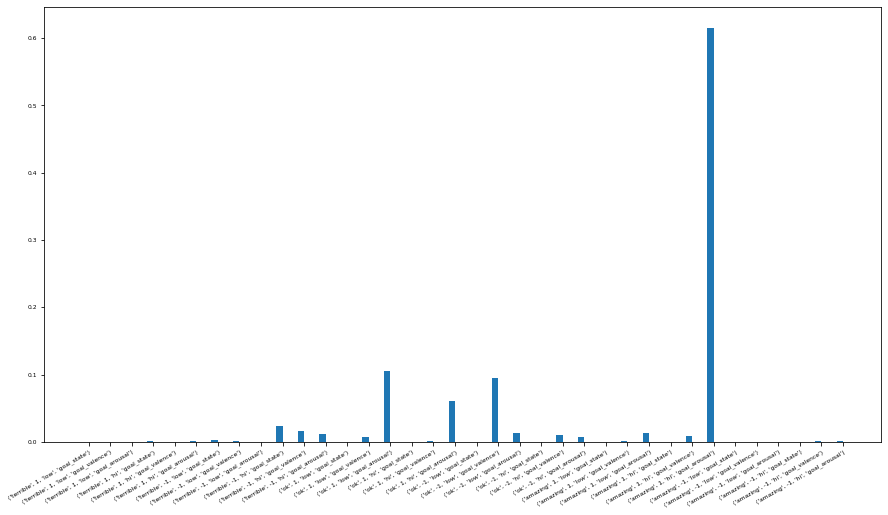

In [27]:
STATE_PRIOR = [100, 1, 1]
rsa_posterior = pragmatic_listener("terrible")
fig = plt.figure()
inference_util.plot_dist(rsa_posterior)
#fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_terrible_alt.pdf")